# Generate synthetic topography files
Create 2D arrays of bottom depth, h, for input to MOM6  
Including both 'designed' topography (flat bottom with continental slope and ridge) and random topography (generated from spectrum)

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

In [3]:
rootdir = '/work/gam/MOM6/inputs/'
config = 'channel'
simulation = '4th-deg'

In [6]:
# ___ HORIZONTAL GRID ___#
# Specify geometry of horizontal grid
# MUST BE CONSISTENT WITH THE MODEL GRID
# Latitude and longitude
SOUTHLAT=-65.0
LENLAT=40.0
WESTLON=0.0
LENLON=60.0

# Number of grid cells
NI=int(LENLON*4)
NJ=int(LENLAT*4)

# Grid point positions (tracer point)
X=np.linspace(WESTLON,WESTLON+LENLON,NI+1)
X1d=(X[1:] + X[:-1]) / 2
Y=np.linspace(SOUTHLAT,SOUTHLAT+LENLAT,NJ+1)
Y1d=(Y[1:] + Y[:-1]) / 2
# 2D mesh of grid point positions
X,Y=np.meshgrid(X1d,Y1d)
# Define xarray data array with dimensions of horizontal grid
# (for broadcasting dimensions of other variables later in the notebook)
hgrid = xr.DataArray(np.ones([NI,NJ]),coords=[X1d,Y1d],dims=['lon','lat'])

# Define lat and lon dimensions set to zero at the midpoint
X0 = xr.DataArray(np.linspace(-NI/2,NI/2,NI),coords=[X1d],dims='lon')
Y0 = xr.DataArray(np.linspace(-NJ/2,NJ/2,NJ),coords=[Y1d],dims='lat')

# ___ VERTICAL GRID ___ #
# Specify geometry of vertical grid
# (based on MOM6 input parameters)

# Number of grid cells
NK = 20

MAXIMUM_DEPTH = 4000
MINIMUM_DEPTH = 0

# Designed topography
Borrowing python scripts from Luwei Yang to generate channel topography with continental slope and ridge

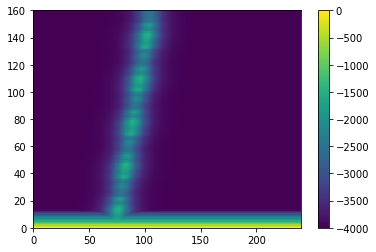

In [43]:
# ___ CREATE TOPOGRAPHY ___ #
# Note that MOM6 takes DEPTH (not HEIGHT) for its topography, so it is positive number

def create_ridge(D=0,A=500,p=1,o=0,r=0,w=1):
    # Create a bumpy ridge by setting a sine wave in the meridional direction and multiplying 
    ridge = (D+A*np.sin(p*(2*np.pi)/LENLAT*hgrid.lat))/np.cosh((X0+o+r*Y0)/w)
    return ridge

# Set bathymetry to maximum depth
depth = MAXIMUM_DEPTH*hgrid

# Create RIDGE 1
D = 2000 # Height off maximum depth
A = 400 # Sine wave amplitude
p = 5 # Wavenumber of ridge in latitude
o = LENLON/2 # Longitudinal offset from centre (positive is to the left)
r = -0.2 # Rotation (poitive is anti-clockwise)
w = 7 # Longitudinal width factor (>1 increases the width, <1 decreases)
r1 = create_ridge(D,A,p,o,r,w)

# Create RIDGE 2
D = 0
A = 200 # Sine wave amplitude
p = 20 # Wavenumber of ridge in latitude
w = 5 # Longitudinal width factor (>1 increases the width, <1 decreases)
r2 = create_ridge(D,A,p,o,r,w)

# Create RIDGE 3
D = 0
A = 100 # Sine wave amplitude
p = 30 # Wavenumber of ridge in latitude
w = 3 # Longitudinal width factor (>1 increases the width, <1 decreases)
r3 = create_ridge(D,A,p,o,r,w)

# Create RIDGE 2, 3, 4 etc.

# Add ridges to bathymetry
depth = depth - r1 - r2 - r3

# Add a continental slope next to Antarctica
depth = np.minimum(depth,3e2*(Y0+NJ/2))

# Unify meridional depth within the sponge layer
ydamp = 2; # Must coincide with width of sponge layer in model
sponge_region = hgrid.coords['lat']>SOUTHLAT+LENLAT-ydamp
# Set topography in sponge region to be the same as the depth at its most southerly grid cell
depth=xr.where(sponge_region,depth.sel(lat=sponge_region).isel(lat=0),depth)

# Impose minimum depth
depth=xr.where(depth<MINIMUM_DEPTH,MINIMUM_DEPTH,depth)

# ___ SAVE OUTPUT ___ #
# Combine arrays to one dataset
depth.name='depth'
depth.transpose('lat','lon')
depth.to_netcdf(rootdir+config+'/'+simulation+'_topography'+'.nc')

# Plot to check
im=plt.pcolormesh(-depth)
plt.colorbar(im)

# Random topography
Generate random topographic fields with power spectra that correspond to the power spectra of the Southern Ocean